In [1]:
library(dplyr)
library(biomaRt)
library(tximport)
library(stringr)
library(Seurat)
library(harmony)
library(ggplot2)
library(Matrix)
library(fgsea)
library(ggrepel)
library(clusterProfiler)
library(org.Hs.eg.db)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: Rcpp



clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects 


**Import Seurat objects**


In [ ]:
#import processed MGC January data (QC'd, log-normalised, clustered and annotated)

setwd("/home/jovyan/data/GCA/MGC/datasets")
MGC<-readRDS("MGC_jan_processed.RDS")

In [ ]:
Idents(MGC)<-"initial_clustering"
DefaultAssay(MGC)<-"RNA"
markers <- FindAllMarkers(MGC, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0)

setwd("/home/jovyan/data/GCA/stats")
write.csv(markers, 'MGC_DEGs.csv')



***MGC alignment to tissue data***



In [2]:
#Import GCA tissue data

setwd("/home/jovyan/data/GCA/R_conversion")
gca<-readRDS('GCA_R.RDS')

gca@meta.data$source<-'tissue'

In [3]:
#import processed MGC January data (QC'd, log-normalised, clustered and annotated)

setwd("/home/jovyan/data/GCA/MGC/datasets")
MGC<-readRDS("MGC_jan_processed.RDS")

MGC@meta.data$source<-'invitro'

In [4]:
Idents(gca)<-"tissue"
tissue<-subset(gca, id = c("tissue"))

Idents(tissue)<-'anno'
tissue<-subset(tissue, id = c('Mac1_tissue', 'Mac2_tissue', 'DC_tissue'))

In [5]:
tissue <- NormalizeData(tissue, verbose = FALSE)
tissue <- FindVariableFeatures(tissue, selection.method = "vst", 
        nfeatures = 2000, verbose = FALSE)

In [6]:
anchors <- FindTransferAnchors(reference = MGC, query = tissue, 
    dims = 1:20)
predictions <- TransferData(anchorset = anchors, refdata = MGC$initial_clustering, 
    dims = 1:20)
tissue <- AddMetaData(tissue, metadata = predictions)
tissue@meta.data$aligned<-tissue@meta.data$predicted.id
MGC@meta.data$aligned<-MGC@meta.data$initial_clustering

Performing PCA on the provided reference using 1754 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 344 anchors

Filtering anchors

	Retained 164 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [7]:
anchors <- FindIntegrationAnchors(object.list = c(tissue, MGC), dims = 1:30)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1399 anchors

Filtering anchors

	Retained 1268 anchors



In [8]:
integrated <- IntegrateData(anchorset = anchors, dims = 1:30)

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [9]:
DefaultAssay(integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(integrated, npcs = 30, verbose = FALSE)
integrated <- RunUMAP(integrated, reduction = "pca", dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:22:12 UMAP embedding parameters a = 0.9922 b = 1.112

21:22:12 Read 3500 rows and found 30 numeric columns

21:22:12 Using Annoy for neighbor search, n_neighbors = 30

21:22:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:22:13 Writing NN index file to temp file /tmp/RtmpeDDAWD/file6029244bc598

21:22:13 Searching Annoy index using 1 thread, search_k = 3000

21:22:13 Annoy recall = 100%

21:22:14 Commencing smooth kNN distance calibration using 1 thread

21:22:15 Initializing fro

In [46]:
table(integrated@meta.data$anno, integrated@meta.data$aligned)

             
              MonoLMGC_leiden MonoMac_leiden MultiLMGC_leiden Osteoclast_leiden
  DC_tissue              2227              8               45                 0
  Mac1_tissue              31            285               74                 0
  Mac2_tissue             204            292               52                 0

In [72]:
setwd("/home/jovyan/data/GCA/MGC/datasets")
saveRDS(integrated, "MGC_tissue_integrated.RDS")



***Sankey plot of label transfer***



In [160]:
table(integrated@meta.data$aligned, integrated@meta.data$source)

                   
                    invitro tissue
  MonoLMGC_leiden       115   2462
  MonoMac_leiden         46    585
  MultiLMGC_leiden      105    171
  Osteoclast_leiden      16      0

In [59]:
library(networkD3)
library(dplyr)
 
# A connection data frame is a list of flows with intensity for each flow
links <- data.frame(
  source=c("DC","DC", "DC", "Mac1", "Mac1", "Mac1", 'Mac2', 'Mac2', 'Mac2'), 
  target=c('MonoMac', 'MonoLMGC', 'MultiLMGC', 'MonoMac', 'MonoLMGC', 'MultiLMGC','MonoMac', 'MonoLMGC', 'MultiLMGC'), 
  value=c(8, 2227, 45, 285, 31,74, 292, 204, 53)
  )
 
# From these flows we need to create a node data frame: it lists every entities involved in the flow
nodes <- data.frame(
  name=c(as.character(links$source), 
  as.character(links$target)) %>% unique()
)
 
# With networkD3, connection must be provided using id, not using real name like in the links dataframe.. So we need to reformat it.
links$IDsource <- match(links$source, nodes$name)-1 
links$IDtarget <- match(links$target, nodes$name)-1

my_color <- 'd3.scaleOrdinal() .domain(["DC", "Mac1", "Mac2", "MonoMac", "MonoLMGC", "MultiLMGC"]).range(["#CE5B5B", "#f79b16", "#f4b7af",  "#d4a87f","#92a8b4", "#95ad92"])'
 
# Make the Network
p <- sankeyNetwork(Links = links, Nodes = nodes,
              Source = "IDsource", Target = "IDtarget",
              Value = "value", NodeID = "name", 
              sinksRight=FALSE, colourScale=my_color)

In [61]:
options(repr.plot.width=10, repr.plot.height=10)
p

HTML widgets cannot be represented in plain text (need html)

In [71]:
nodes$blank<-nodes$name
nodes$name<-""

# A connection data frame is a list of flows with intensity for each flow
links <- data.frame(
  source=c("DC","DC", "DC", "Mac1", "Mac1", "Mac1", 'Mac2', 'Mac2', 'Mac2'), 
  target=c('MonoMac', 'MonoLMGC', 'MultiLMGC', 'MonoMac', 'MonoLMGC', 'MultiLMGC','MonoMac', 'MonoLMGC', 'MultiLMGC'), 
  value=c(8, 2227, 45, 285, 31,74, 292, 204, 53)
  )
 
# From these flows we need to create a node data frame: it lists every entities involved in the flow
nodes <- data.frame(
  name=c(as.character(links$source), 
  as.character(links$target)) %>% unique()
)
 
# With networkD3, connection must be provided using id, not using real name like in the links dataframe.. So we need to reformat it.
links$IDsource <- match(links$source, nodes$name)-1 
links$IDtarget <- match(links$target, nodes$name)-1

links$group <- as.factor(c("link1", "link2", "link3", "link1", "link2", "link3","link1", "link2", "link3")) 

my_color <- 'd3.scaleOrdinal() .domain(["link1", "link2", "link3", 
"DC", "Mac1", "Mac2", 
"MonoMac", "MonoLMGC", "MultiLMGC"]). 
range(["#92a8b4", "#efd8e1", "#95ad92", 
"#CE5B5B", "#4fb7af", "#f59b1a",  
"#92a8b4", "#efd8e1", "#95ad92"])'
 
# Make the Network
p <- sankeyNetwork(Links = links, Nodes = nodes,
              Source = "IDsource", Target = "IDtarget",
              Value = "value", NodeID = "name", 
              sinksRight=FALSE, colourScale=my_color,fontSize = 0, LinkGroup="group")
p

HTML widgets cannot be represented in plain text (need html)



***Calculate DEGs and conserved programmes***



In [148]:
setwd("/home/jovyan/data/GCA/MGC/datasets")
integrated<-readRDS("MGC_tissue_integrated.RDS")

In [161]:
#find the DEGs between multiLMGCs and those tissue macs that are predicted to be LMGC macs

Idents(integrated)<-'aligned'
stats<-FindAllMarkers(integrated, only.pos = TRUE, logfc.threshold = 0.25, min.pct = 0.25)

Calculating cluster MonoMac_leiden

Calculating cluster MonoLMGC_leiden

Calculating cluster MultiLMGC_leiden

Calculating cluster Osteoclast_leiden



In [162]:
stats<-stats %>% filter(p_val_adj<0.05)

In [163]:
ensembl_gene <-
  useMart("ENSEMBL_MART_ENSEMBL", 
          host="https://grch37.ensembl.org",
          path="/biomart/martservice", 
          dataset = "hsapiens_gene_ensembl")

t2g<-biomaRt::getBM(attributes=c("external_gene_name","entrezgene_id"),mart=ensembl_gene)

colnames(t2g)<-c('gene', 'entrezgene_id')

In [164]:
stats<-left_join(x = stats, y = t2g, by = 'gene')

In [165]:
cells<-unique(stats$cluster)

In [194]:
l<-list()
for(i in 1:length(cells)){ 
    test<-stats[stats$cluster == cells[i],]
    l[cells[i]] = list(test$entrezgene_id)
    }
names(l)<-cells

In [196]:
OR_analysis<-data.frame()
for (i in 1:length(unique(cells))){
    tryCatch({
        temp <- enrichGO(gene = l[[i]],
                #universe      = names(geneList),
                OrgDb         = org.Hs.eg.db,
                ont           = "ALL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
                readable      = TRUE)
        temp<-as.data.frame(temp)
        temp$celltype<-names(l[i])
        OR_analysis<-rbind(OR_analysis, temp)},
        error = function(e) {an.error.occured <<- TRUE})
    }

In [200]:
setwd("/home/jovyan/data/GCA/over-representation")
write.csv(OR_analysis, 'unfiltered_integrated_MGC_OR_analysis.csv')



***Filtering step to pathways at this stage***



In [203]:
setwd("/home/jovyan/data/GCA/stats")
OR_analysis_integrated<-read.csv('filtered_integrated_MGC_OR_analysis.csv')

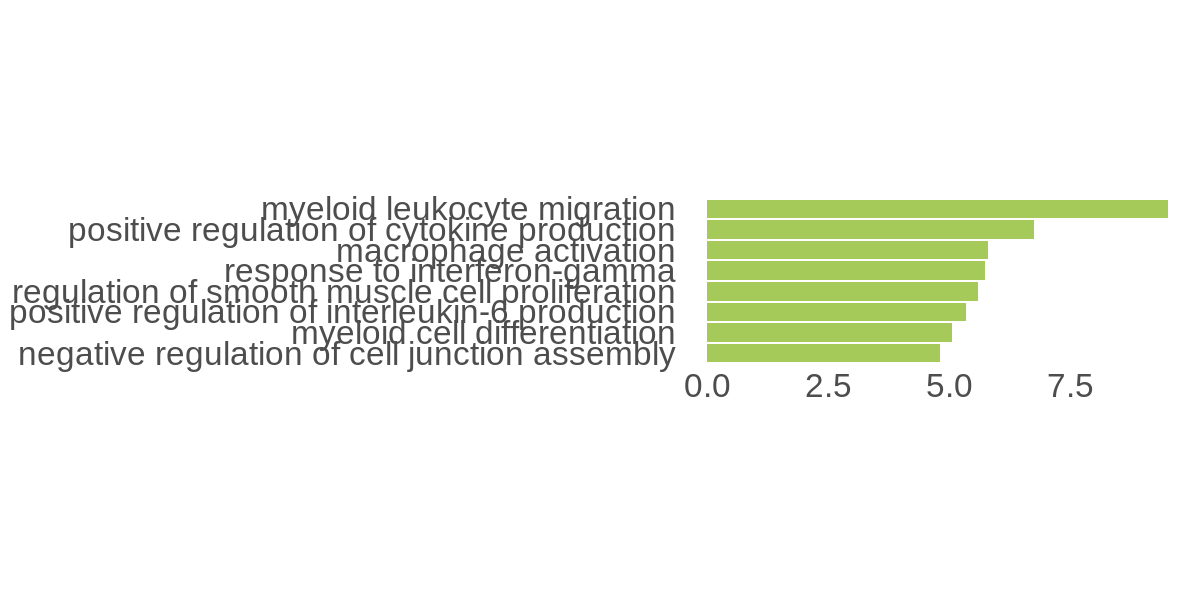

In [220]:
library(forcats)
options(repr.plot.width=10, repr.plot.height=5)


temp<-OR_analysis_integrated %>% slice_head(n=8)

#temp$celltype <- factor(temp$celltype, levels = rev(c("Mac1", 'Mac2')))


temp$order<--log10(temp$p.adjust)
#temp<-within(temp, order[celltype=='MyoFB'] <- order*-1)

temp<-temp%>% mutate(Description = fct_reorder(Description, order))



ggplot(temp, aes(Description, order))+
geom_bar(stat="identity", fill = "#a6ca59") +coord_flip()+
    theme(panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), 
    axis.line = element_blank(), 
    axis.ticks = element_blank(),
    text = element_text(size=15),
    aspect.ratio=1/3,
    axis.title=element_blank(),
    axis.text=element_text(size = 20),
    legend.position='none',
    strip.background = element_blank(),
    strip.text.x = element_blank())


setwd('/home/jovyan/data/GCA/figures')
ggsave("OR_analysis_integrated_multi_LMGC.png", plot = last_plot(), device = NULL, path = NULL,width = 10, height = 5,  scale = 1)



***Show expression of example common marker genes***



In [2]:
setwd("/home/jovyan/data/GCA/stats")
OR_analysis_integrated<-read.csv('filtered_integrated_MGC_OR_analysis.csv')

In [3]:
#extract genes of interest from OR analysis

a<-strsplit(OR_analysis_integrated$geneID, '/')
res <- do.call(c, a)

In [4]:
setwd("/home/jovyan/data/GCA/MGC/datasets")
integrated<-readRDS("MGC_tissue_integrated.RDS")

In [5]:
#find the DEGs between multiLMGCs and those tissue macs that are predicted to be LMGC macs

Idents(integrated)<-'aligned'
stats_integrated<-FindMarkers(integrated, ident.1 = 'MultiLMGC_leiden', logfc.threshold = -Inf, min.pct = -Inf, min.diff.pct = -Inf)
stats_integrated$gene<-rownames(stats_integrated)

In [235]:
#prepare data

###label genes of interest in threshold column
#firstly by those that are significant (i.e. fold change > 1.5 and adjusted p value <0.05)
stats_integrated$sig_genes<-ifelse(stats_integrated$p_val_adj<0.05 & abs(stats_integrated$avg_log2FC) > 0.585, 'sig', 'not_sig')

#make extra columns including genes if they are both signficant AND fulfil extra condition (e.g. listed as ISG)

stats_integrated$OR_genes<-ifelse(stats_integrated$gene %in% res & stats_integrated$sig_genes == 'sig', stats_integrated$gene, '')

In [238]:
range(stats_integrated$avg_log2FC)

[1] -2.175303  2.721510

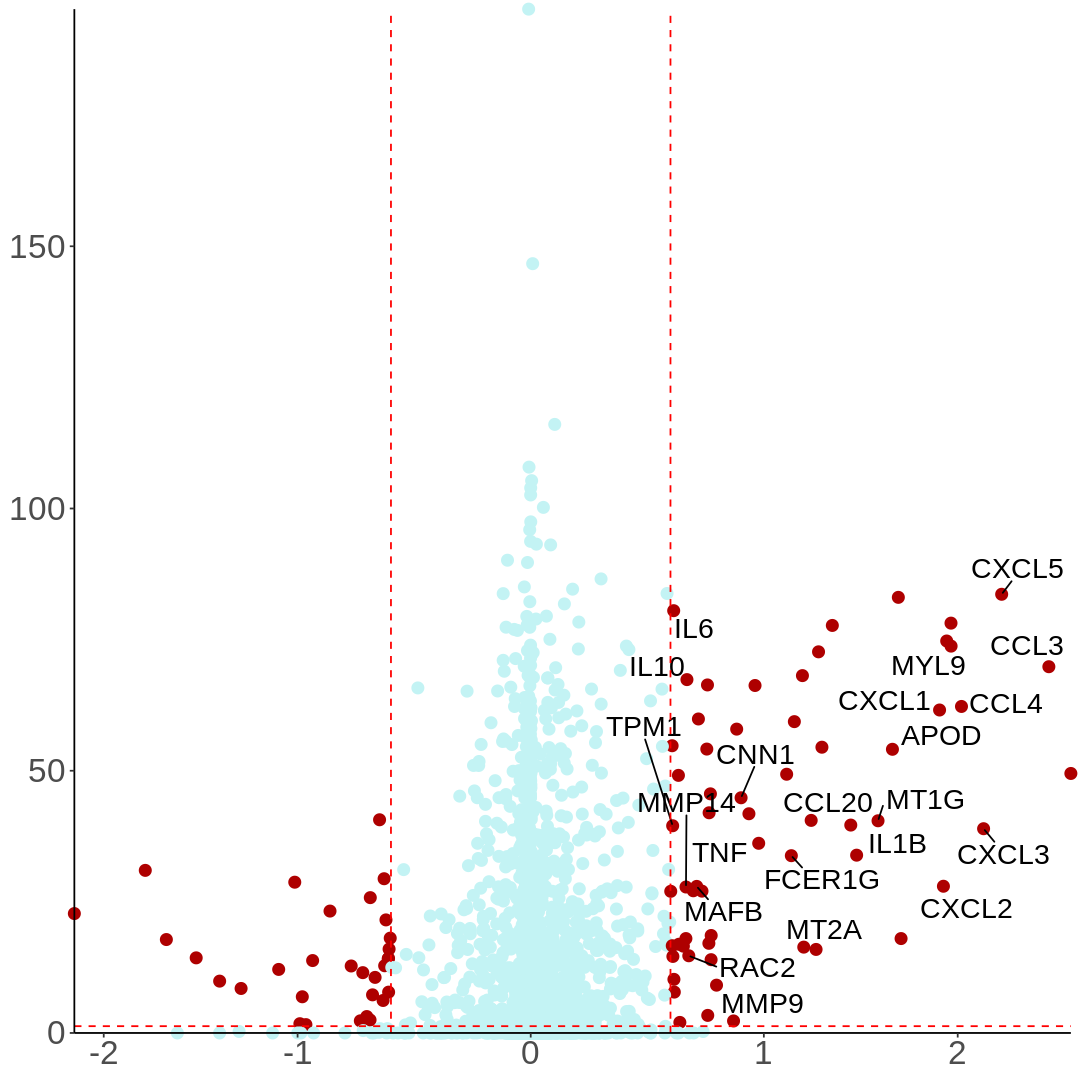

In [243]:
options(repr.plot.width=9, repr.plot.height=9)
options(ggrepel.max.overlaps = Inf)

ggplot(stats_integrated) +
        geom_point(aes(x=avg_log2FC, y=-log10(p_val_adj), colour=sig_genes), size = 3)+
scale_color_manual(values=c('#C3F3F4', "#ae0000"))+
geom_text_repel(aes(x=avg_log2FC, y=-log10(p_val_adj), 
                    label = OR_genes), size = 6, force = 20, color = 'black', family = "Helvetica")+

#fold change of 1.5: 2^x = 1.5 --> x (ln 2) = ln(1.5) --> x=0.584
geom_vline(xintercept = -0.585, linetype = "dashed", color = "red", size = 0.5)+

geom_vline(xintercept = 0.585, linetype = "dashed", color = "red", size = 0.5)+

#p val adjusted: -log10(0.05) = 1.3
geom_hline(yintercept = 1.30, linetype = "dashed", color = "red", size = 0.5)+

theme(panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.background = element_blank(),
      axis.line = element_line(colour = "black"),
      axis.text = element_text(size =20),
      axis.title = element_blank(),
      strip.text.x = element_blank(),
      strip.background = element_blank(),
        panel.spacing.x = unit(3, "lines"),
     panel.spacing.y = unit(6, "lines"),
     legend.position = 'none',
     text=element_text(family="Helvetica"))+

scale_y_continuous(expand = c(0, 0))+
scale_x_continuous(trans=scales::pseudo_log_trans(base = 10), expand = c(0, 0))+
coord_cartesian(clip = "off")

setwd('/home/jovyan/data/GCA/figures')
ggsave("volcano_integrated_MGC.png", plot = last_plot(), device = NULL, path = NULL,width = 9, height = 9,  scale = 1)